# Radar training data analyses.ipynb

(Include description of code here!)

By Sharon Jones, September 2017, Python v3, DEA v1.5.2, Radar data from `simoncube`

Modified after `Check_for_statistical_difference_in_slope.ipynb` in Geoscience Australia's `GWBAGDC` Git repo. 

** Code dependencies **
- training data shape files for different land cover types (derived from ArcGIS over the TC Debbie landfall region). The code will look for the training datasets in `/g/data1/w85/training_shapefiles/`. Ensure that al of the training shapefiles are executable.

## Imports and functions

In [1]:
# Import the libraries we need in the code and tell matplotlib to display the plots here
%matplotlib inline
import fiona
import shapely.geometry
import rasterio
import rasterio.features
import geopandas as gp
import datacube
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats
import pandas

In [2]:
# Set up some functions to use later in the code
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

def geometry_mask(geom, geobox, all_touched=False, invert=False):
    """
    rasterize geometry into a binary mask where pixels that overlap geometry are False
    """
    return rasterio.features.geometry_mask([geom],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

## Define the extent of the radar files

In [15]:
cache = '/g/data/u46/users/sj9724/xarray.pickle.debbie'
lon = 148.68, 148.21
lat = -20.30, -20.12 # call for partial Debbie area

## Read in the training data shapefile and create a mask from it. 
This code reads in the shapefile and identifies and lists all of the polygons witin it.

In [7]:
shp = gp.GeoDataFrame.from_file('/g/data1/w85/training_shapefiles/Crops_test.shp')
print (shp.head)

<bound method NDFrame.head of     BLUE Classname  Classvalue   Count  GREEN  RED  \
0    122   Class 1           1   12024      4   78   
1    210   Class 2           2   10645    123  219   
2    163   Class 3           3    5249    207   88   
3     16   Class 4           4   14019    193  200   
4    132   Class 5           5    4889     49  242   
5     48   Class 6           6   11700    140  190   
6     58   Class 7           7   21556    152  221   
7    173   Class 8           8   25360    185   56   
8     33   Class 9           9    9863     96  130   
9     46  Class 10          10   19274    228   57   
10    82  Class 11          11   32143    245  162   
11   224  Class 12          12   61363    149  139   
12   192  Class 13          13  225116    253  103   
13    90  Class 14          14  128997    250    5   
14   224  Class 15          15   65256     84  131   
15   231  Class 16          16   78497    118  234   

                                             geomet

This section filters our polygons, to find only those that are within the bounding box we specified above. It then combines all the relevant polygons into a single polygon that we can use to create our mask.

In [17]:
# Create a bounding box from the locations specified above
box = shapely.geometry.box(lon[1], lat[1], lon[0], lat[0], ccw = True)
# Only get the polygons that intersect the bounding box (i.e. remove all the irrelevant ones)
filtered = shp.where(shp.intersects(box)).dropna()
# Combine all of the relevant polygons into a single polygon
shp_union = shapely.ops.unary_union(filtered.geometry)

## Read in the data we want to apply the mask to

In [ ]:
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')

In [14]:
try:
    with open(cache, 'rb') as file:
        z = pickle.load(file) # this only takes tens of seconds. (6GB)
except:
    # this may be 5 to 10 mintues (seeking through half a terabyte)
    z = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, output_crs='epsg:3577', resolution=(-25,25))
    with open(cache, 'wb') as file:
        pickle.dump(z, file, protocol=-1) # save result to disk

NameError: name 'dc' is not defined

In [20]:
# Create the mask based on our shapefile
mask = geometry_mask(warp_geometry(shp_union, shp.crs, z.crs), z.geobox, invert=True)
# Get data only where the mask is 'true'
data_masked = z.where(mask)
print(data_masked)

NameError: name 'z' is not defined

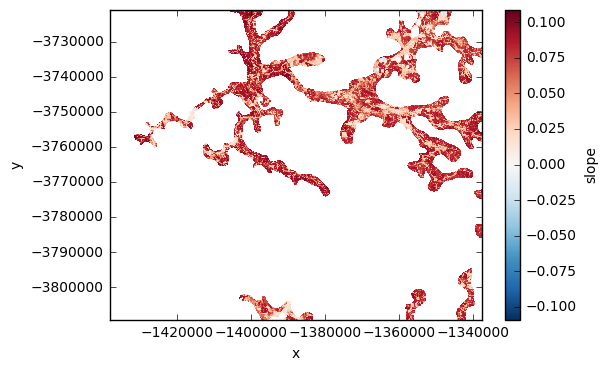

In [13]:
# Plot the masked dataset
fig = data_masked.slope.plot(cmap = 'RdBu_r')

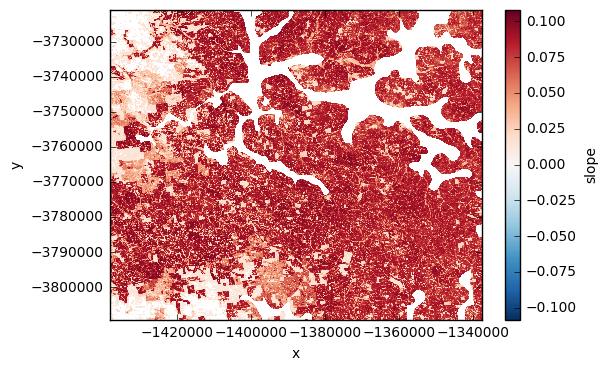

In [16]:
# Get data only where the mask is 'false'
data_maskedF = data.where(~ mask)
# Plot the opposite masked dataset
fig = data_maskedF.slope.plot()

## Now to check for statistical difference

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   7.00000000e+00,   9.00000000e+00,
          1.20000000e+01,   1.40000000e+01,   2.20000000e+01,
          3.10000000e+01,   5.90000000e+01,   5.10000000e+01,
          5.90000000e+01,   4.20000000e+01,   5.60000000e+01,
          3.00000000e+01,   2.20000000e+01,   3.50000000e+01,
          3.90000000e+01,   3.40000000e+01,   4.70000000e+01,
          4.50000000e+01,   5.20000000e+01,   3.30000000e+01,
          2.40000000e+01,   1.20000000e+01,   5.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   1.60000000e+01,
          4.00000000e+01,   1.54000000e+02,   3.40000000e+02,
          6.92000000e+02,   1.46600000e+03,   2.89800000e+03,
        

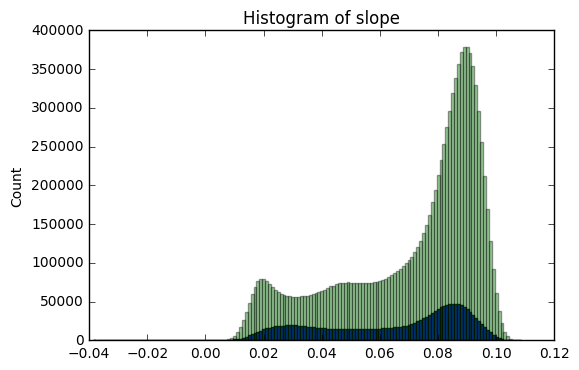

In [23]:
minval = data.slope.min()
maxval = data.slope.max()
bin_values = np.arange(start = minval, stop = maxval, step = 0.001)
data_masked.slope.plot.hist(bins = bin_values)
data_maskedF.slope.plot.hist(alpha = 0.4, bins = bin_values)

In [24]:
# Create a new numpy array with just the slope values
data_masked2 = np.array(data_masked.slope)
data_maskedF2 = np.array(data_maskedF.slope)

# Remove nan values
data_masked_nonan = data_masked2[~np.isnan(data_masked2)]
data_maskedF_nonan = data_maskedF2[~np.isnan(data_maskedF2)]
print(data_masked_nonan)
print(data_maskedF_nonan)

[ 0.09142149  0.09089205  0.08961107 ...,  0.08105325  0.08207757
  0.08268268]
[ 0.07239243  0.07112248  0.07154097 ...,  0.08575163  0.08625634
  0.08739026]


[array([ 0.09142149,  0.09089205,  0.08961107, ...,  0.08105325,
        0.08207757,  0.08268268]), array([ 0.07239243,  0.07112248,  0.07154097, ...,  0.08575163,
        0.08625634,  0.08739026])]
[1865046, 11154209]
Ttest_indResult(statistic=-368.50312387218332, pvalue=0.0)
Ks_2sampResult(statistic=0.15071826719837977, pvalue=0.0)


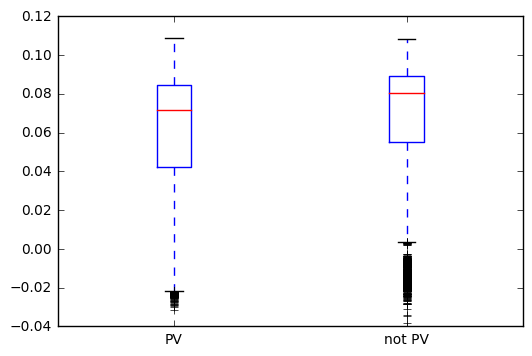

In [27]:
masked_both = [data_masked_nonan,data_maskedF_nonan]
print(masked_both)
# How many data points are in each of my NDVI lists?
size = ([len(i) for i in masked_both])
print(size)

bp = plt.boxplot(masked_both)
plt.xticks([1,2],['PV', 'not PV'])

stats_ttest = scipy.stats.ttest_ind(data_masked_nonan,data_maskedF_nonan, equal_var = 'False')
print(stats_ttest)

# Test with a Kolmogorov-Smirnov test 
# Our null hypothesis that 2 independent samples are drawn from the same continuous distribution
stats_KS = scipy.stats.ks_2samp(data_masked_nonan,data_maskedF_nonan)
print(stats_KS)